In [6]:
'''An example to show how to set up an pommerman game programmatically'''
import time
import pommerman
from pommerman import agents
from pommerman import constants as c
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility
from pommerman import forward_model
from pommerman import constants

# Notebook 6.3
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ReinforceModel(forward_model.ForwardModel):
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def get_rewards(agents, game_type, step_count, max_steps):

        def any_lst_equal(lst, values):
            '''Checks if list are equal'''
            return any([lst == v for v in values])

        alive_agents = [num for num, agent in enumerate(agents) \
                        if agent.is_alive]
        if game_type == constants.GameType.FFA:
            if len(alive_agents) == 1:
                # An agent won. Give them +1, others -1.
                return [2 * int(agent.is_alive) - 1 for agent in agents]
            elif step_count >= max_steps:
                # Game is over from time. Everyone gets -1.
                return [-1] * 4
            else:
                # Game running: 0 for alive, -1 for dead.
                
                return [int(agent.is_alive) - 1 for agent in agents]


class NewAgent(agents.BaseAgent):
    """The Random Agent that returns random actions given an action_space."""

    def __init__(self, Character=Bomber, *args, **kwargs):
        super(NewAgent,self).__init__(Character,*args, **kwargs)
        self.seq = [c.Action.Right, c.Action.Up, c.Action.Left, c.Action.Down]
        self.index = 0
    
    def act(self, obs, action_space):
        if self.index == 4:
            self.index = 0
        action = self.seq[self.index]
        self.index += 1
        return 0
    
# Print all possible environments in the Pommerman registry
print(pommerman.REGISTRY)

# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

# Create a set of agents (exactly four)
agent_list = [
    NewAgent(config["agent"](0, config["game_type"])),
    agents.SimpleAgent(config["agent"](1, config["game_type"])),
    agents.SimpleAgent(config["agent"](2, config["game_type"])),
    agents.RandomAgent(config["agent"](3, config["game_type"])),
    # agents.DockerAgent("pommerman/simple-agent", port=12345),
]

env.set_agents(agent_list)
env.set_training_agent(0) #<- Does not call act method on training agents in env.act
env.model = ReinforceModel()
env.set_init_game_state(None)

# Run the episodes just like OpenAI Gym
#for i_episode in range(1):
#    state = env.reset()
#    done = False
#    while not done:  
#        actions = env.act(state)
#        state, reward, done, info = env.step(actions)

        #Update


#    print('Episode {} finished'.format(i_episode))
#    print(info)
#time.sleep(2)
#env.close()

    

['PommeFFACompetition-v0', 'PommeFFACompetitionFast-v0', 'PommeFFAFast-v0', 'PommeFFA-v1', 'PommeRadio-v2', 'PommeTeamCompetition-v0', 'PommeTeamCompetitionFast-v0', 'PommeTeamCompetition-v1', 'PommeTeam-v0', 'PommeTeamFast-v0']


## Notebook 6.3 Network and Train

In [14]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.ffn = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_outputs),
        )
        
        self.ffn.apply(self.init_weights)
        
        #self.hidden = nn.Linear(n_inputs, n_hidden)
        #self.hidden2 = nn.Linear(n_hidden, n_hidden)
        #self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = flatten_state(x)
        #print(x)
        #x = self.hidden(x)
        #x = F.relu(x)
        #x = F.relu(self.hidden2(x))
        #x = self.out(x)
        
        x = self.ffn(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))
    
    def init_weights(m, *args):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

# Example:
# def forward(self, x):
#     x = flatten_state(x)
# where x is np.atleast1d(S[0])

# Flattens a state s on the form list<dict> where each dict contains information of a state
def flatten_state(s):
    #print("\n Flatten: ",s)
    return torch.from_numpy(np.array([flatten_state_aux(x) for x in s])).float()

def flatten_state_aux(s):
    # Lists
    #print("\n Augs: ",s)
    alive = [1 if x in s['alive'] else 0 for x in range(10,14)]
    #print(alive)
    board = s['board']
    bomb_blast_strength = s['bomb_blast_strength']
    bomb_life = s['bomb_life']
    # Tuples
    position = s['position']
    # Ints
    blast_strength = s['blast_strength']
    can_kick = s['can_kick']
    ammo = s['ammo']
    # Enums
    teammate = s['teammate'] #9 for FFA
    enemies = s['enemies'] #11,12,13 for FFA and training agent id = 0
    
    a = np.append(np.array(alive),np.array(board).flatten())
    a = np.append(a,np.array(bomb_blast_strength).flatten())
    a = np.append(a,np.array(bomb_life).flatten())
    a = np.append(a,position[0])
    a = np.append(a,position[1])
    a = np.append(a,blast_strength)
    a = np.append(a,can_kick)
    a = np.append(a,ammo)
    # Commented out as we get size 376 but expected 372. I assume we calculated wrong.
    # Makes sense to ignore these imo
    #a = np.append(a,teammate.value)
    #a = np.append(a,[e.value for e in enemies])
    #print(np.shape(a))
    return a.astype(float)
    

# training settings
n_inputs = 372
n_hidden = 500
n_outputs = env.action_space.n

num_episodes = 100
#rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 0.9 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 25 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        done = False
        #policy.train()
        while not done:
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(np.atleast_1d(s[0]))
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            
            actions = env.act(s)
            actions.insert(0,a)
            
            #print(actions)
            
            s1, r, done, _ = env.step(actions)
            #print(r)
            rollout.append((s, a, r[0]))
            #print("\n\nrollout:",rollout,"\n\n")
            s = s1
        # prepare batch
        print('done with episode:',i)
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy([s[0] for s in states]).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        #policy.eval()
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(1):
                s = env.reset()
                reward = 0
                done = False
                while not done:
                    env.render()
                    with torch.no_grad():
                        probs = policy(np.atleast_1d(s[0]))
                        a = probs.argmax().item()
                        print(probs, "max actions: ", a,probs.argmax())
                        
                    actions = env.act(s)
                    actions.insert(0,a)
                    
                    s, r, done, _ = env.step(actions)
                    reward += r[0]
                validation_rewards.append(reward)
                env.render(close=True)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
            time.sleep(2)
    env.close()
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
done with episode: 0
done with episode: 1
done with episode: 2
done with episode: 3
done with episode: 4
done with episode: 5
done with episode: 6
done with episode: 7
done with episode: 8
done with episode: 9
done with episode: 10
done with episode: 11
done with episode: 12
done with episode: 13
done with episode: 14
done with episode: 15
done with episode: 16
done with episode: 17
done with episode: 18
done with episode: 19
done with episode: 20
done with episode: 21
done with episode: 22
done with episode: 23
done with episode: 24
tensor([[0.0004, 0.0001, 0.1183, 0.0001, 0.0413, 0.8398]]) max actions:  5 tensor(5)
tensor([[0.0006, 0.0001, 0.3435, 0.0001, 0.0873, 0.5684]]) max actions:  5 tensor(5)
tensor([[1.9227e-05, 8.1340e-07, 1.8249e-01, 1.4657e-06, 3.3414e-02, 7.8408e-01]]) max actions:  5 tensor(5)
tensor([[0.0015, 0.0001, 0.1469, 0.0002, 0.0877, 0.7636]]) max actions:  5 tensor(5)
tensor([[0.0002, 0.0000, 0.2668, 0.0000, 0.0171, 0.7159]]) max actions:  5 tensor

tensor([[6.0605e-08, 7.4982e-11, 9.9665e-01, 7.0848e-10, 3.3474e-03, 2.2056e-07]]) max actions:  2 tensor(2)
tensor([[1.3239e-08, 6.8017e-12, 9.9985e-01, 2.4699e-12, 1.5239e-04, 1.5678e-08]]) max actions:  2 tensor(2)
tensor([[1.3418e-08, 7.5066e-12, 9.9869e-01, 6.2965e-11, 1.3093e-03, 4.5208e-08]]) max actions:  2 tensor(2)
tensor([[6.3244e-14, 1.8211e-16, 9.9999e-01, 8.7618e-15, 6.2692e-06, 1.7767e-11]]) max actions:  2 tensor(2)
tensor([[2.1311e-10, 4.0175e-12, 9.9993e-01, 4.2929e-12, 6.9146e-05, 2.0303e-08]]) max actions:  2 tensor(2)
tensor([[1.2925e-08, 9.8469e-11, 9.9825e-01, 1.2806e-12, 1.7547e-03, 2.7975e-09]]) max actions:  2 tensor(2)
tensor([[1.5539e-10, 2.1867e-12, 9.9978e-01, 3.8407e-12, 2.2215e-04, 1.1157e-08]]) max actions:  2 tensor(2)
tensor([[6.8542e-10, 1.9070e-11, 9.9961e-01, 2.6596e-11, 3.8880e-04, 6.5609e-09]]) max actions:  2 tensor(2)
tensor([[7.2569e-10, 3.2162e-13, 9.9902e-01, 1.5154e-11, 9.8196e-04, 2.5342e-09]]) max actions:  2 tensor(2)
tensor([[3.0273e-11

tensor([[3.9328e-09, 5.3395e-11, 9.9961e-01, 3.8983e-11, 3.8807e-04, 4.8174e-08]]) max actions:  2 tensor(2)
tensor([[1.5524e-06, 7.3673e-10, 9.9729e-01, 1.8801e-08, 2.7080e-03, 2.6215e-06]]) max actions:  2 tensor(2)
tensor([[2.4408e-08, 2.8330e-10, 9.9692e-01, 1.5755e-09, 3.0817e-03, 1.1064e-06]]) max actions:  2 tensor(2)
tensor([[1.7913e-08, 2.4949e-11, 9.9910e-01, 7.1816e-10, 9.0381e-04, 6.5766e-08]]) max actions:  2 tensor(2)
tensor([[4.2824e-08, 8.2759e-11, 9.9571e-01, 7.0107e-11, 4.2921e-03, 4.0370e-08]]) max actions:  2 tensor(2)
tensor([[2.5219e-09, 4.3253e-11, 9.9984e-01, 3.6859e-12, 1.5757e-04, 6.1599e-09]]) max actions:  2 tensor(2)
tensor([[2.1027e-08, 5.2108e-11, 9.9987e-01, 2.4175e-10, 1.3047e-04, 2.2633e-08]]) max actions:  2 tensor(2)
tensor([[1.4393e-09, 1.0258e-12, 9.9972e-01, 5.2607e-12, 2.8428e-04, 2.5128e-09]]) max actions:  2 tensor(2)
tensor([[5.6459e-11, 8.8911e-15, 9.9984e-01, 4.4136e-14, 1.6230e-04, 1.0901e-10]]) max actions:  2 tensor(2)
tensor([[2.8339e-10

tensor([[9.3152e-07, 5.3456e-09, 9.9338e-01, 1.0105e-08, 6.6180e-03, 1.2156e-06]]) max actions:  2 tensor(2)
tensor([[1.7745e-08, 1.1028e-10, 9.9980e-01, 1.5434e-10, 1.9971e-04, 9.2014e-08]]) max actions:  2 tensor(2)
tensor([[8.6882e-09, 1.5845e-10, 9.9887e-01, 7.5000e-11, 1.1331e-03, 2.2518e-08]]) max actions:  2 tensor(2)
tensor([[1.5631e-07, 1.9417e-09, 9.9861e-01, 2.5318e-09, 1.3907e-03, 1.1619e-06]]) max actions:  2 tensor(2)
tensor([[1.8055e-07, 2.3675e-10, 9.9933e-01, 3.8267e-10, 6.7035e-04, 5.0786e-07]]) max actions:  2 tensor(2)
tensor([[2.4495e-07, 6.7710e-08, 9.9886e-01, 9.1073e-09, 1.1367e-03, 1.4046e-06]]) max actions:  2 tensor(2)
tensor([[9.5577e-08, 6.5083e-10, 9.9685e-01, 3.1389e-09, 3.1533e-03, 1.0436e-07]]) max actions:  2 tensor(2)
tensor([[1.1414e-08, 3.4726e-10, 9.9948e-01, 1.0905e-09, 5.1924e-04, 1.5979e-07]]) max actions:  2 tensor(2)
tensor([[2.0115e-08, 7.8035e-10, 9.9972e-01, 1.0929e-10, 2.7535e-04, 4.5596e-06]]) max actions:  2 tensor(2)
tensor([[2.5962e-08

tensor([[2.6012e-14, 8.4726e-16, 1.0000e+00, 3.1564e-16, 3.8381e-07, 2.2596e-13]]) max actions:  2 tensor(2)
tensor([[7.5590e-11, 2.7595e-13, 9.9999e-01, 4.5583e-13, 1.4299e-05, 7.8165e-11]]) max actions:  2 tensor(2)
tensor([[4.8422e-14, 1.5358e-17, 1.0000e+00, 4.4947e-17, 7.5738e-07, 2.6420e-14]]) max actions:  2 tensor(2)
tensor([[1.2533e-16, 3.6986e-20, 1.0000e+00, 1.4683e-20, 7.5587e-09, 2.5295e-17]]) max actions:  2 tensor(2)
tensor([[4.0585e-15, 5.3403e-18, 1.0000e+00, 1.2186e-17, 1.8690e-07, 8.5969e-13]]) max actions:  2 tensor(2)
tensor([[2.7848e-13, 1.1001e-16, 1.0000e+00, 1.3272e-16, 9.8315e-08, 1.5014e-13]]) max actions:  2 tensor(2)
tensor([[9.7613e-16, 2.4242e-19, 1.0000e+00, 2.2627e-18, 1.0952e-08, 1.0331e-15]]) max actions:  2 tensor(2)
tensor([[4.0323e-14, 1.4808e-17, 1.0000e+00, 1.1133e-17, 4.8047e-07, 4.2160e-14]]) max actions:  2 tensor(2)
tensor([[6.8796e-12, 1.9020e-15, 1.0000e+00, 4.3533e-17, 5.8146e-07, 2.5714e-12]]) max actions:  2 tensor(2)
tensor([[6.0110e-12

done with episode: 75
done with episode: 76
done with episode: 77
done with episode: 78
done with episode: 79
done with episode: 80
done with episode: 81
done with episode: 82
done with episode: 83
done with episode: 84
done with episode: 85
done with episode: 86
done with episode: 87
done with episode: 88
done with episode: 89
done with episode: 90
done with episode: 91
done with episode: 92
done with episode: 93
done with episode: 94
done with episode: 95
done with episode: 96
done with episode: 97
done with episode: 98
done with episode: 99
tensor([[1.0018e-14, 5.0162e-20, 1.0000e+00, 1.6317e-18, 1.2277e-08, 2.7163e-15]]) max actions:  2 tensor(2)
tensor([[1.0770e-16, 3.8243e-21, 1.0000e+00, 2.3930e-20, 3.8090e-09, 3.7059e-16]]) max actions:  2 tensor(2)
tensor([[1.0102e-17, 3.4674e-20, 1.0000e+00, 2.2740e-20, 4.6358e-09, 3.4469e-17]]) max actions:  2 tensor(2)
tensor([[1.3015e-16, 3.2687e-18, 1.0000e+00, 6.7492e-21, 3.9965e-09, 4.3474e-16]]) max actions:  2 tensor(2)
tensor([[4.385

tensor([[1.5859e-13, 4.7969e-16, 1.0000e+00, 3.3819e-14, 9.5197e-07, 3.2232e-13]]) max actions:  2 tensor(2)
tensor([[6.0450e-18, 4.5800e-22, 1.0000e+00, 9.2682e-23, 1.8002e-10, 8.2762e-18]]) max actions:  2 tensor(2)
tensor([[1.0722e-14, 7.7922e-19, 1.0000e+00, 4.3169e-19, 3.5448e-08, 1.5184e-13]]) max actions:  2 tensor(2)
tensor([[1.1405e-14, 1.5458e-18, 1.0000e+00, 2.7906e-19, 2.1000e-08, 2.7321e-14]]) max actions:  2 tensor(2)
tensor([[3.8806e-14, 6.8354e-18, 1.0000e+00, 4.0903e-17, 2.1945e-07, 3.1173e-14]]) max actions:  2 tensor(2)
tensor([[9.6983e-16, 2.2815e-19, 1.0000e+00, 1.3028e-19, 5.6583e-10, 1.9923e-15]]) max actions:  2 tensor(2)
tensor([[5.4029e-14, 2.5860e-18, 1.0000e+00, 2.5770e-17, 2.5938e-08, 7.0592e-13]]) max actions:  2 tensor(2)
tensor([[3.2288e-14, 1.0706e-16, 1.0000e+00, 1.4657e-17, 6.0286e-09, 2.8016e-13]]) max actions:  2 tensor(2)
tensor([[6.9328e-17, 1.7714e-19, 1.0000e+00, 6.2383e-20, 1.4724e-09, 3.9154e-16]]) max actions:  2 tensor(2)
tensor([[1.5598e-17

tensor([[9.9830e-13, 7.0966e-15, 1.0000e+00, 5.9135e-15, 1.9930e-06, 6.2685e-11]]) max actions:  2 tensor(2)
tensor([[2.5503e-11, 2.3844e-13, 9.9997e-01, 4.4941e-13, 2.8985e-05, 3.2738e-10]]) max actions:  2 tensor(2)
tensor([[9.1757e-13, 1.8391e-15, 1.0000e+00, 2.6273e-16, 2.7749e-08, 9.9408e-12]]) max actions:  2 tensor(2)
tensor([[6.1336e-12, 7.7036e-15, 1.0000e+00, 8.9567e-15, 1.3139e-06, 3.6122e-12]]) max actions:  2 tensor(2)
tensor([[6.7423e-11, 1.4909e-13, 9.9998e-01, 5.2963e-13, 2.2849e-05, 1.7212e-10]]) max actions:  2 tensor(2)
tensor([[5.3943e-14, 4.8147e-16, 1.0000e+00, 1.8896e-15, 6.3887e-07, 7.4506e-14]]) max actions:  2 tensor(2)
tensor([[6.9003e-12, 3.3546e-14, 1.0000e+00, 7.2819e-14, 3.9002e-07, 1.3325e-11]]) max actions:  2 tensor(2)
tensor([[1.2928e-14, 9.0520e-17, 1.0000e+00, 1.1777e-16, 2.9196e-08, 7.4259e-14]]) max actions:  2 tensor(2)
tensor([[1.0532e-13, 1.0035e-14, 1.0000e+00, 3.1599e-15, 4.2248e-08, 6.0481e-12]]) max actions:  2 tensor(2)
tensor([[3.3329e-11

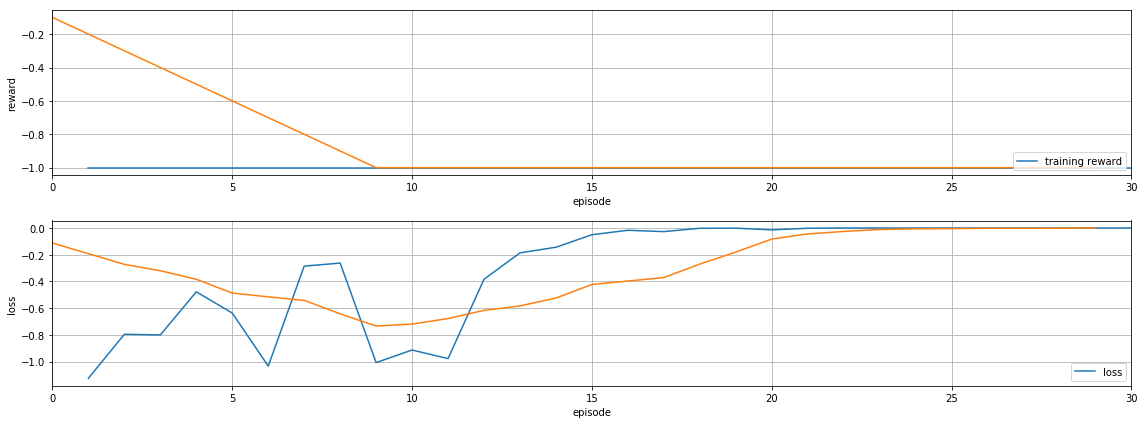

In [9]:
# plot results
import matplotlib.pyplot as plt

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()